## **Approach 1 : Transfer Learning using VGG16 Pretrained model**

In [ ]:
# Loading Dataset from Google Drive and extracting
from google.colab import drive
drive.mount('/content/gdrive')

!unrar x /content/gdrive/MyDrive/iccad_official.rar -d /content/

Streaming output truncated to the last 5000 lines.
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5743.png3.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5743.png4.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5743.png6.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5743.png7.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5743.png8.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5743.png9.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5744.png1.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5744.png2.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5744.png3.png      97%  OK 
Extracting  /content/iccad-official/icca

In [ ]:
#Importing all required libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
import time

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.utils import  plot_model
from tensorflow.keras.applications.vgg16 import preprocess_input

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.exceptions import ConvergenceWarning
from warnings import simplefilter

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Found GPU at: /device:GPU:0
Using:
	• TensorFlow version: 2.12.0
	• tf.keras version: 2.12.0
	• Running on GPU


In [ ]:
# Information in the following link used for reference -  https://keras.io/api/applications/
# VGG16 CNN pretrained on imagenet is downloaded as base for transfer learning
base = VGG16(weights="imagenet")
base.trainable = False 

# Last 2 fully connected layers are removed to obtain feature extraction model
feature_extraction_model = models.Model(inputs=base.input, outputs=base.layers[-3].output)
feature_extraction_model.summary()

553467096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
#Hypter-parameters for each of the classification algorithms are set here, so that grid-search can find the best configurations
param_grid_linsvm = {'C': [1, 10, 100], 
                    'kernel': ['poly'],
                     'degree':[1,2,3]} 

param_grid_kersvm = {'C': [1, 10], 
                    'gamma': [0.01, 0.001],
                    'kernel': ['rbf','sigmoid']} 

param_grid_ranfor = {'max_depth': [4, 8, 12],
                    'max_features': [10, 20]}

param_grid_knn = {'n_neighbors':[3, 5, 7]}

In [ ]:
# Function to obtain paths to training and validation datasets; count number of images
# Takes path to base folder as input and returns paths to train and validation datasets
def dataset_analysis(folder):
    # Basically navigating to each sub folder and counting number of images present
    base_dir = os.path.join(os.path.dirname(folder))
    train_dir = os.path.join(base_dir, 'train')
    validation_dir = os.path.join(base_dir, 'test')

    train_hotspot_dir = os.path.join(train_dir, 'train_hs')
    train_not_hotspot_dir = os.path.join(train_dir, 'train_nhs')

    validation_hotspot_dir = os.path.join(validation_dir, 'test_hs')  
    validation_not_hotspot_dir = os.path.join(validation_dir, 'test_nhs')  

    num_hs_tr = len(os.listdir(train_hotspot_dir))
    num_nhs_tr = len(os.listdir(train_not_hotspot_dir))

    num_hs_val = len(os.listdir(validation_hotspot_dir))
    num_nhs_val = len(os.listdir(validation_not_hotspot_dir))

    total_train = num_hs_tr + num_nhs_tr
    total_val = num_hs_val + num_nhs_val

    print('The dataset contains:')
    print(total_train, "Training images")
    print(total_val, "Validation images")

    print('\nThe training set contains:')
    print(num_hs_tr, "Images with hotspot")
    print(num_nhs_tr, "Images without hotspot")

    print('\nThe validation set contains:')
    print(num_hs_val, "Images with hotspot")
    print(num_nhs_val, "Images without hotspot")
    print()
    
    return train_dir, validation_dir

In [ ]:
# Function to extract features from images using pre-trained VGGNET model
# Takes train and validation paths and returns extracted features and labels
def feature_extractor(train_dir, validation_dir):
    # Image data generators
    # The following lines are to specify paths from which training and validation images are to be loaded
    # Some other parameters such as batch size, target size and type of classification are specified
    image_gen_train = ImageDataGenerator(rescale=1./255, preprocessing_function = preprocess_input)
    image_gen_val = ImageDataGenerator(rescale=1./255, preprocessing_function = preprocess_input)

    train_data_gen = image_gen_train.flow_from_directory(directory=train_dir,
                                                        batch_size=32,
                                                        shuffle=True,
                                                        target_size=(224, 224),
                                                        class_mode='binary')

    val_data_gen = image_gen_val.flow_from_directory(directory=validation_dir,
                                                    batch_size=32,
                                                    shuffle=False,
                                                    target_size=(224, 224),
                                                    class_mode='binary')
    
    # The following code is used to extract labels from the data generator
    # This is necessary because transfer learning on extracted features is done using sk-learn
    number_of_examples = len(train_data_gen.filenames)
    number_of_generator_calls = math.ceil(number_of_examples / (1.0 * 32)) 
    train_labels = []
    for i in range(0,int(number_of_generator_calls)):
        train_labels.extend(np.array(train_data_gen[i][1]))
    number_of_examples = len(val_data_gen.filenames)
    number_of_generator_calls = math.ceil(number_of_examples / (1.0 * 32)) 
    val_labels = []
    for i in range(0,int(number_of_generator_calls)):
        val_labels.extend(np.array(val_data_gen[i][1]))
    train_labels = np.array(train_labels)
    val_labels = np.array(val_labels)

    # Extracting features from the pretrained neural network
    features_train = feature_extraction_model.predict(train_data_gen)
    features_val = feature_extraction_model.predict(val_data_gen)
    print()
    
    return features_train, features_val, train_labels, val_labels

In [ ]:
# Function to train and validate different classifiers using sk-learn (grid search)
# The extracted features and labels are passed as inputs and all the metrics are printed
def classifiers(X_train, X_val, y_train, y_val):
    print("Linear SVM")
    grid_linsvm = GridSearchCV(estimator = SVC(), param_grid = param_grid_linsvm, cv = 5)
    grid_linsvm.fit(X_train, y_train)
    linearsvm_start_time = time.time()
    y_predict = grid_linsvm.predict(X_val)
    linearsvm_end_time = time.time()
    linearsvm_inference_time = linearsvm_end_time - linearsvm_start_time
    print("balanced accuracy = ", balanced_accuracy_score(y_val, y_predict))
    print(grid_linsvm.best_params_)
    print('Classification Report: \n', classification_report(y_val,y_predict))
    print('Confusion Matrix: \n', confusion_matrix(y_val,y_predict))
    print("Linear/Polynomial SVM inference time duration = ",linearsvm_inference_time)
    print()

    print("Kernel SVM")
    grid_kersvm = GridSearchCV(estimator = SVC(), param_grid = param_grid_kersvm, cv = 5)
    grid_kersvm.fit(X_train, y_train)
    start_kernsvm = time.time()
    y_predict = grid_kersvm.predict(X_val)
    end_kernsvm = time.time()
    kernsvm_inference_time = end_kernsvm - start_kernsvm
    print("balanced accuracy = ", balanced_accuracy_score(y_val, y_predict))
    print(grid_kersvm.best_params_)
    print('Classification Report: \n', classification_report(y_val, y_predict))
    print('Confusion Matrix: \n', confusion_matrix(y_val, y_predict))
    print("Kernal SVM inference time duration = ",kernsvm_inference_time)
    print()

    print("Random Forest")
    grid_ranfor = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid_ranfor, cv = 5)
    grid_ranfor.fit(X_train, y_train)
    rf_start_time = time.time()
    y_predict = grid_ranfor.predict(X_val)
    rf_end_time = time.time()
    rf_inference_time = rf_end_time - rf_start_time
    print("balanced accuracy = ", balanced_accuracy_score(y_val, y_predict))
    print(grid_ranfor.best_params_)
    print('Classification Report: \n', classification_report(y_val, y_predict))
    print('Confusion Matrix: \n', confusion_matrix(y_val, y_predict))
    print("Random Forest inference time duration = ",rf_inference_time)
    print()

    print("k-Nearest Neighbours")
    grid_knn = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = param_grid_knn, cv = 5)
    grid_knn.fit(X_train, y_train)
    knn_start_time = time.time()
    y_predict = grid_knn.predict(X_val)
    knn_end_time = time.time()
    knn_inference_time = knn_end_time - knn_start_time
    print("balanced accuracy = ", balanced_accuracy_score(y_val, y_predict))
    print(grid_knn.best_params_)
    print('Classification Report: \n', classification_report(y_val, y_predict))
    print('Confusion Matrix: \n', confusion_matrix(y_val, y_predict))
    print("k-Nearest Neighbour inference time duration = ",knn_inference_time)
    print()

There are 5 datasets provided by ICCAD. The same steps have been followed for each of the benchmarks. 

Benchmark 1

In [ ]:
# Path to ICCAD1 dataset
folder = '/content/iccad-official/iccad1/'

# Obtaining training and validation directories
train_dir, validation_dir = dataset_analysis(folder)

# Extracting training and validation features and labels
X_train, X_val, y_train, y_val = feature_extractor(train_dir, validation_dir)

# Classification on extracted features
classifiers(X_train, X_val, y_train, y_val)

The dataset contains:
439 Training images
4905 Validation images

The training set contains:
99 Images with hotspot
340 Images without hotspot

The validation set contains:
226 Images with hotspot
4679 Images without hotspot

Found 439 images belonging to 2 classes.
Found 4905 images belonging to 2 classes.
154/154 [==============================] - 31s 198ms/step

Linear SVM
balanced accuracy =  0.9513983586992909
{'C': 100, 'degree': 2, 'kernel': 'poly'}
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.37      0.98      0.54       226
         1.0       1.00      0.92      0.96      4679

    accuracy                           0.92      4905
   macro avg       0.69      0.95      0.75      4905
weighted avg       0.97      0.92      0.94      4905

Confusion Matrix: 
 [[ 222    4]
 [ 372 4307]]
Linear/Polynomial SVM inference time duration =  0.6715941429138184

Kernel SVM
balanced accuracy =  0.8977548905200605
{'C': 10, 'gamma': 0

Benchmark 2

In [ ]:
# Same steps as benchmark 1
folder = '/content/iccad-official/iccad2/'

train_dir, validation_dir = dataset_analysis(folder)

X_train, X_val, y_train, y_val = feature_extractor(train_dir, validation_dir)

classifiers(X_train, X_val, y_train, y_val)

The dataset contains:
5459 Training images
41796 Validation images

The training set contains:
174 Images with hotspot
5285 Images without hotspot

The validation set contains:
498 Images with hotspot
41298 Images without hotspot

Found 5459 images belonging to 2 classes.
Found 41796 images belonging to 2 classes.
1307/1307 [==============================] - 245s 187ms/step

Linear SVM
balanced accuracy =  0.6102843744584615
{'C': 100, 'degree': 3, 'kernel': 'poly'}
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.89      0.22      0.35       498
         1.0       0.99      1.00      1.00     41298

    accuracy                           0.99     41796
   macro avg       0.94      0.61      0.67     41796
weighted avg       0.99      0.99      0.99     41796

Confusion Matrix: 
 [[  110   388]
 [   13 41285]]

Kernel SVM
balanced accuracy =  0.5491120372817727
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Classification Report: 
        

Benchmark 3

In [ ]:
# Same steps as benchmark 1
folder = '/content/iccad-official/iccad3/'

train_dir, validation_dir = dataset_analysis(folder)

X_train, X_val, y_train, y_val = feature_extractor(train_dir, validation_dir)

classifiers(X_train, X_val, y_train, y_val)

The dataset contains:
5552 Training images
48141 Validation images

The training set contains:
909 Images with hotspot
4643 Images without hotspot

The validation set contains:
1808 Images with hotspot
46333 Images without hotspot

Found 5552 images belonging to 2 classes.
Found 48141 images belonging to 2 classes.
1505/1505 [==============================] - 291s 193ms/step

Linear SVM
balanced accuracy =  0.9252822046310004
{'C': 100, 'degree': 3, 'kernel': 'poly'}
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.29      0.94      0.44      1808
         1.0       1.00      0.91      0.95     46333

    accuracy                           0.91     48141
   macro avg       0.64      0.93      0.70     48141
weighted avg       0.97      0.91      0.93     48141

Confusion Matrix: 
 [[ 1703   105]
 [ 4233 42100]]

Kernel SVM
balanced accuracy =  0.886988554765817
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Classification Report: 
        

Benchmark 4

In [ ]:
# Same steps as benchmark 1
folder = '/content/iccad-official/iccad4/'

train_dir, validation_dir = dataset_analysis(folder)

X_train, X_val, y_train, y_val = feature_extractor(train_dir, validation_dir)

classifiers(X_train, X_val, y_train, y_val)

The dataset contains:
4547 Training images
32067 Validation images

The training set contains:
95 Images with hotspot
4452 Images without hotspot

The validation set contains:
177 Images with hotspot
31890 Images without hotspot

Found 4547 images belonging to 2 classes.
Found 32067 images belonging to 2 classes.
1003/1003 [==============================] - 170s 169ms/step

Linear SVM
balanced accuracy =  0.7367236953298149
{'C': 100, 'degree': 2, 'kernel': 'poly'}
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.70      0.47      0.57       177
         1.0       1.00      1.00      1.00     31890

    accuracy                           1.00     32067
   macro avg       0.85      0.74      0.78     32067
weighted avg       1.00      1.00      1.00     32067

Confusion Matrix: 
 [[   84    93]
 [   36 31854]]

Kernel SVM
balanced accuracy =  0.8675688675585036
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Classification Report: 
         

Benchmark 5

In [ ]:
# Same steps as benchmark 1
folder = '/content/iccad-official/iccad5/'

train_dir, validation_dir = dataset_analysis(folder)

X_train, X_val, y_train, y_val = feature_extractor(train_dir, validation_dir)

classifiers(X_train, X_val, y_train, y_val)

The dataset contains:
2742 Training images
19368 Validation images

The training set contains:
26 Images with hotspot
2716 Images without hotspot

The validation set contains:
41 Images with hotspot
19327 Images without hotspot

Found 2742 images belonging to 2 classes.
Found 19368 images belonging to 2 classes.
606/606 [==============================] - 114s 187ms/step

Linear SVM
balanced accuracy =  0.8288284934383467
{'C': 100, 'degree': 2, 'kernel': 'poly'}
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.61      0.66      0.64        41
         1.0       1.00      1.00      1.00     19327

    accuracy                           1.00     19368
   macro avg       0.81      0.83      0.82     19368
weighted avg       1.00      1.00      1.00     19368

Confusion Matrix: 
 [[   27    14]
 [   17 19310]]

Kernel SVM
balanced accuracy =  0.6828492176368962
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Classification Report: 
            

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


balanced accuracy =  0.5973540112593655
{'n_neighbors': 5}
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.50      0.20      0.28        41
         1.0       1.00      1.00      1.00     19327

    accuracy                           1.00     19368
   macro avg       0.75      0.60      0.64     19368
weighted avg       1.00      1.00      1.00     19368

Confusion Matrix: 
 [[    8    33]
 [    8 19319]]



In [ ]:
# Bar plots of balanced accuracy of each model for all benchmarks

ba_lsvm = {'benchmark1':0.946, 'benchmark2':0.610, 'benchmark3':0.925, 'benchmark4':0.737, 'benchmark5':0.829}
ba_ksvm = {'benchmark1':0.898, 'benchmark2':0.549, 'benchmark3':0.887, 'benchmark4':0.868, 'benchmark5':0.682} 
ba_rf = {'benchmark1':0.863, 'benchmark2':0.501, 'benchmark3':0.668, 'benchmark4':0.662, 'benchmark5':0.5}
ba_knn = {'benchmark1':0.813, 'benchmark2':0.517, 'benchmark3':0.699, 'benchmark4':0.823, 'benchmark5':0.597}

bal_acc1 = list(ba_lsvm.values())
bal_acc2 = list(ba_ksvm.values())
bal_acc3 = list(ba_rf.values())
bal_acc4 = list(ba_knn.values())

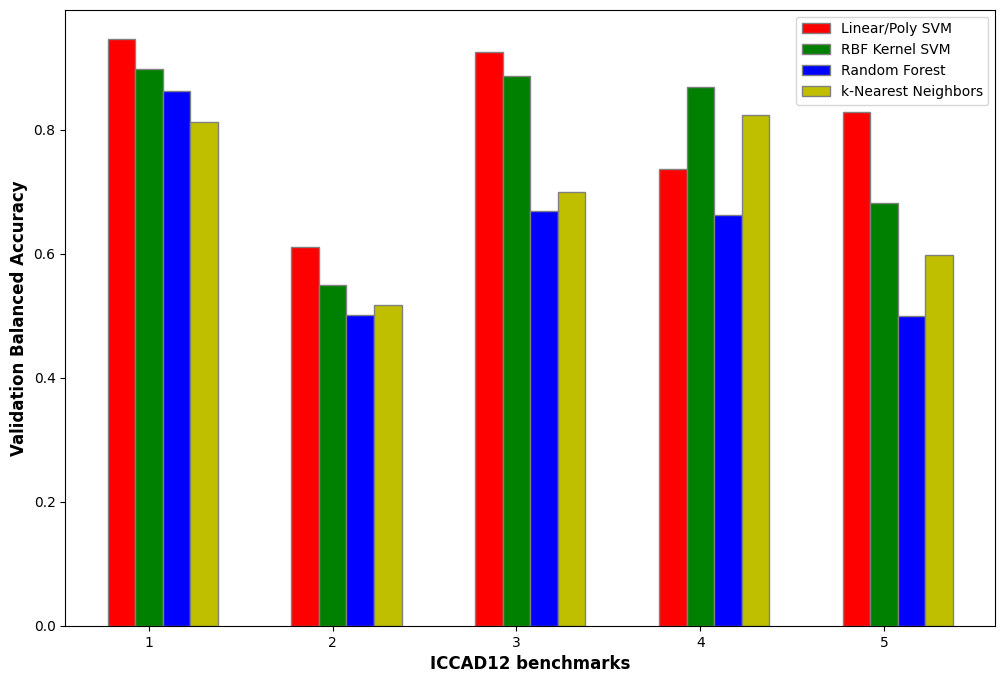

In [ ]:
barWidth = 0.15
fig = plt.subplots(figsize =(12, 8))

br1 = np.arange(len(bal_acc1))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

plt.bar(br1, bal_acc1, color ='r', width = barWidth,
        edgecolor ='grey', label ='Linear/Poly SVM')
plt.bar(br2, bal_acc2, color ='g', width = barWidth,
        edgecolor ='grey', label ='RBF Kernel SVM')
plt.bar(br3, bal_acc3, color ='b', width = barWidth,
        edgecolor ='grey', label ='Random Forest')
plt.bar(br4, bal_acc4, color ='y', width = barWidth,
        edgecolor ='grey', label ='k-Nearest Neighbors')

plt.xlabel('ICCAD12 benchmarks', fontweight ='bold', fontsize = 12)
plt.ylabel('Validation Balanced Accuracy', fontweight ='bold', fontsize = 12)
plt.xticks([r + barWidth for r in range(len(bal_acc1))],
        ['1', '2', '3', '4', '5'])
 
plt.legend()
plt.show()

In [ ]:
# Printing average validation balanced accuracy of each model

ave1 = sum(bal_acc1)/5
ave2 = sum(bal_acc2)/5
ave3 = sum(bal_acc3)/5
ave4 = sum(bal_acc4)/5
print("Average Balanced Accuracy:")
print("Linear/Poly SVM :", ave1)
print("RBF Kernel SVM :", ave2)
print("Random Forest :", ave3)
print("k-Nearest Neighbors :", ave4)

Average Balanced Accuracy:
Linear/Poly SVM : 0.8093999999999999
RBF Kernel SVM : 0.7767999999999999
Random Forest : 0.6388
k-Nearest Neighbors : 0.6898


**References:**

*   Liao, L.; Li, S.; Che, Y.; Shi, W.; Wang, X. Lithography Hotspot Detection Method Based on Transfer Learning Using Pre-Trained Deep Convolutional Neural Network. Appl. Sci. 2022, 12, 2192. https://doi.org/10.3390/app12042192
*   H. Yang, Y. Lin, B. Yu and E. F. Y. Young, "Lithography hotspot detection: From shallow to deep learning," 2017 30th IEEE International System-on-Chip Conference (SOCC), Munich, Germany, 2017, pp. 233-238, doi: 10.1109/SOCC.2017.8226047. </br>
* https://www.tensorflow.org/ </br>
* https://scikit-learn.org/stable/ </br>
* https://github.com/sumedhachugh/Lithography-Hotspot-Detection </br>
* https://www.geeksforgeeks.org/bar-plot-in-matplotlib/
